In [1]:
import torch
import torch.nn.functional as F
import numpy as np
from typing import Optional
from torchinfo import summary

## 5.1 Positional Encoding
The authors reference the fact that neural networks opt to learn low-frequency functions rather than high-frequency functions; ie they opt for smoothing approximations. This obviously would not yield highly specific & accurate renderings!

To get around this, they employ a positional encoding to project a low-frequency signal to a high-frequency one, using a this positonal encoding as a mapping. They are trying to coax more information out of a smaller amount of information.  

For example, they reference the following formula:
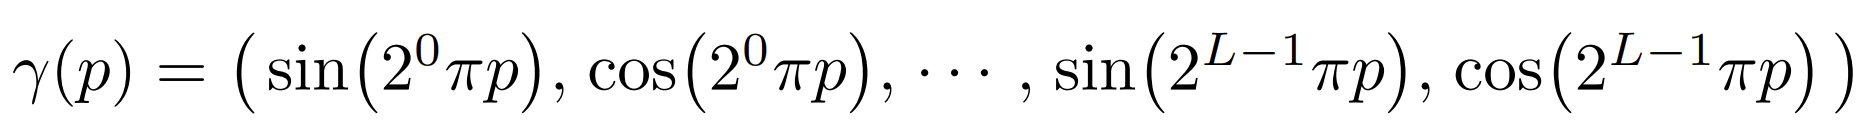

<br>
What this is doing is taking one number, and turning into a vector of length `2L`. If `L`=10, as it is for positional encoding of the camera position, then γ(x) will go from being size 3 to a size 20 vector! This is also why Figure 7 of the original work has the numbers 60 and 24 when referencing γ(x) and γ(d), respectively.

In [2]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, L: int):
        super().__init__()
        
        self.L = L
        self.register_buffer('map', torch.tensor([(2**i) * torch.pi for i in range(L)]))
                
    def forward(self, x: torch.Tensor)->torch.Tensor:
        """Generate positional encoding for tensor x.
        Args:
            x (torch.Tensor): (Bx3) The input vector x (camera position) or d (camera direction)

        Returns:
            torch.Tensor: (Bx2L) A higher dimensional mapping of the input vector
        """
        
        b, xyz = x.shape
        out = torch.zeros((b, self.L*2 * xyz)).to(x.device) # 3 = xyz
        expanded = x.unsqueeze(-1).expand((-1, -1, self.L))
        
        # Multiple Nx3xL 'expanded' with L 'map'. Reshape to Nx3*L & use slicing trick
        out[:, 0::2] = torch.sin(expanded * self.map).reshape((b, self.L*xyz))
        out[:, 1::2] = torch.cos(expanded * self.map).reshape((b, self.L*xyz))
        
        return out
        

In [3]:
# Test for Answer and Shape Naively. Go row by row (x0, y0, z0), (x1, y1, z1), ... and fill in the encoding

L = 10
PE = PositionalEncoding(L=L)
test = torch.randn(size=(64, 3)) 

ans = torch.zeros((64, 2*L * 3))
for row in range(64):
    for col in range(3):
        
        p = test[row, col]
        
        ans_col = col * 2*L 
        ans[row,  (ans_col):(ans_col + 2*L) : 2] = torch.tensor([ np.sin(2**i * np.pi * p) for i in range(L) ])
        ans[row, (1 + ans_col):(ans_col + 2*L) : 2] = torch.tensor([ np.cos(2**i * np.pi * p) for i in range(L) ])
        
        # ensure all entries are filled out
        assert torch.all(ans[row, (1 + ans_col):(ans_col + 2*L)])

assert torch.allclose(ans, PE(test))

## A: Additional Implementation Details
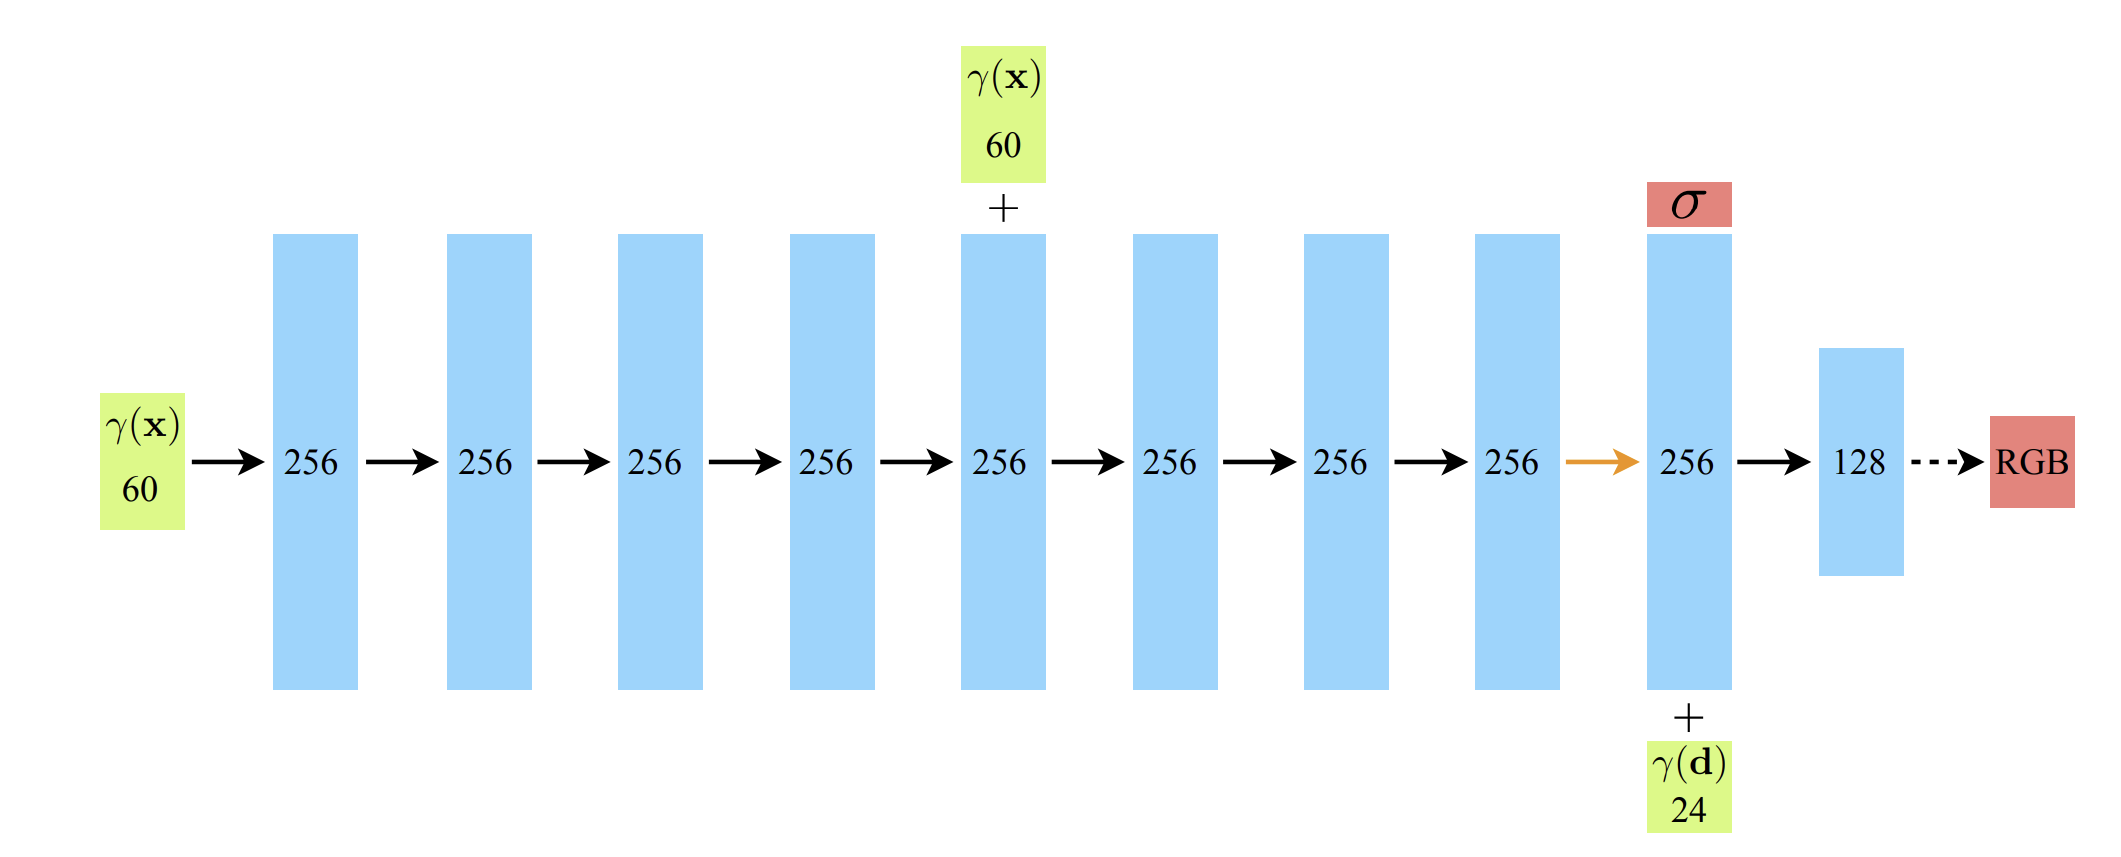

In [24]:
#TODO Add more flexibility, better documentation to these classes

class FFN(torch.nn.Module):
    def __init__(self, in_feats: int, num_layers: int, out_feats: Optional[int]=None):
        super().__init__()
        
        layers = []
        for layer  in range(num_layers):
            if layer == 0:
                layers.append(torch.nn.Linear(in_feats, 256))
            elif out_feats and layer == num_layers-1:
                layers.append(torch.nn.Linear(256, out_feats))
            else:
                layers.append(torch.nn.Linear(256, 256))
                
            layers.append(torch.nn.ReLU())
        
        self.network = torch.nn.Sequential(*layers)
        
    def forward(self, x: torch.Tensor)->torch.Tensor:
        return self.network(x)
        

class NeRF(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = torch.nn.ModuleDict({
            "x_pe": PositionalEncoding(10),
            "d_pe": PositionalEncoding(4),
            "ffn1": FFN(in_feats=60, num_layers=5),
            "ffn2": FFN(in_feats=60+256, out_feats=257, num_layers=3),
            "proj": torch.nn.Linear(in_features=256+24, out_features=128),
            "out": torch.nn.Linear(in_features=128, out_features=3)
        })
        
    def forward(self, x: torch.Tensor, d: torch.Tensor):
        
        gamma_x = self.model["x_pe"](x)
        
        hidden_feats = torch.cat((gamma_x, self.model["ffn1"](gamma_x)), dim=-1)
        hidden_feats = self.model["ffn2"](hidden_feats)
        
        sigma, feats = hidden_feats[:, 0], hidden_feats[:, 1:]
        
        gamma_d = self.model["d_pe"](d)
        rgb = F.relu(self.model["proj"](torch.cat((feats, gamma_d), dim=-1)))
        
        rgb = F.sigmoid(self.model["out"](rgb))
        
        return sigma, rgb

In [28]:
model = NeRF()
model.to("cuda")
summary(model, input_size=((64, 3), (64, 3)), depth=4, col_names=( "input_size", "output_size", "num_params"))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NeRF                                     [64, 3]                   [64]                      --
├─ModuleDict: 1-1                        --                        --                        --
│    └─PositionalEncoding: 2-1           [64, 3]                   [64, 60]                  --
│    └─FFN: 2-2                          [64, 60]                  [64, 256]                 --
│    │    └─Sequential: 3-1              [64, 60]                  [64, 256]                 --
│    │    │    └─Linear: 4-1             [64, 60]                  [64, 256]                 15,616
│    │    │    └─ReLU: 4-2               [64, 256]                 [64, 256]                 --
│    │    │    └─Linear: 4-3             [64, 256]                 [64, 256]                 65,792
│    │    │    └─ReLU: 4-4               [64, 256]                 [64, 256]                 --
│    │    │    └─Linear: 4-